## Importação das bibliotecas

Iremos usar adicional biblioteca de visualização do pacote ia898

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
from keras.datasets import mnist

import pandas as pd


In [10]:
import torch
from torch.autograd import Variable
import torch.optim as optim

## Funções já discutidas em notebooks anteriores

In [30]:

def oneHotIt2(Y,k):
    Y = Y.reshape(-1,1)
    i = np.arange(k).reshape(1,k)
    Y_oh = (Y == i).astype(int)
    return Y_oh

def oneHotIt(Y, n_classes):
    ones = torch.sparse.torch.eye(n_classes)
    return ones.index_select(0,Y)

def softmax(Z):
    # computes softmax for all samples, normalize among classes (columns)
    # input Z: scores; shape: samples rows x classes columns
    # output S: same shape of input
    EZ = torch.exp(Z)
    S = EZ / torch.sum(EZ,1,keepdim=True) # normaliza nas classes - colunas
    return S

def predict(X,WT):
    Y_oh_hat = softmax(X.mm(WT))
    # escolhe a maior probabilidade entre as classes
    # maxs, indices = torch.max(x, [dim])

    val,Y_hat = torch.max(Y_oh_hat,1) # mantém o resultado como matriz bidimensional
    return val,Y_hat







def getAccuracy(X,WT, Y):
    Y_hat = predict(X,WT)
    accuracy = torch.sum(Y_hat == Y)/(float(len(Y)))
    return accuracy

## Carregamento dos dados do MNIST, disponível no `Keras`.

O Keras possui facilidade para carregar o dataset MNIST

In [12]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print("X_train.shape=",X_train.shape)
print("Y_train.shape=",Y_train.shape)
print("X_test.shape=",X_test.shape)
print("Y_test.shape=",Y_test.shape)

X_train.shape= (60000, 28, 28)
Y_train.shape= (60000,)
X_test.shape= (10000, 28, 28)
Y_test.shape= (10000,)


## Organizando e normalizando os dados

Neste exemplo utilizaremos 500 amostras de treinamento e 100 amostras para testes.


In [20]:
n_train = 1000
n_test = 200

Y = Y_train[:n_train]
Y_oh = oneHotIt2(Y,10)

X = X_train[:n_train].reshape((-1,28*28))/255.
X_bias = np.hstack([np.ones((n_train,1)),X]) # incluído X00 como 1 para gerar bias no W
testY = Y_test[:n_test]
testX = X_test[:n_test].reshape((-1,28*28))/255.
testX_bias = np.hstack([np.ones((n_test,1)),testX]) # incluído X00 como 1 para gerar bias no W

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)
print('Y_oh.shape:', Y_oh.shape)

X.shape: (1000, 784)
Y.shape: (1000,)
Y_oh.shape: (1000, 10)


## Visualizando os dados

nb = ia.nbshow(ncols=20)
for i in range(60):
    nb.nbshow(np.uint8(X[i].reshape((28,28))*255),'%d'% (Y_train[i],))
nb.nbshow()

## Visualizando uma imagem com o matplotlib

plt.imshow(np.reshape(X[0],(28,28)),cmap = 'gray') # retirando primeira coluna (bias no W)
print('class:',Y[0])

## Laço principal - treinamento

In [21]:
n_amostras = X_bias.shape[0] # number of training examples
n_atributos = X_bias.shape[1] # number of attributes (features, pixels + 1(bias))
n_classes = 10         # number of classes
WT = np.zeros((n_atributos,n_classes)) # n. de linhas é igual a número de atributos (features, pixels)
epochs = 1000
learningRate = 0.5



In [62]:
##Criando tensores:
#X_bias = torch.cat((ones, X), 1)
n_train = 1000

X = torch.from_numpy(X_train[:n_train].reshape((-1,28*28))/255.).type(torch.FloatTensor)
ones = torch.ones(n_train,1)
ones = ones.type(torch.FloatTensor)
X_bias = torch.cat((ones, X), 1)
testY = torch.from_numpy(Y_test[:n_test]).type(torch.LongTensor)

print(X_bias.size())
#X_tensor = torch.from_numpy(Xc).type(torch.FloatTensor)
#X_tensor = Variable(torch.from_numpy(X_bias).type(torch.FloatTensor))

#Y_tensor = torch.from_numpy(Y).type(torch.LongTensor)
Y = torch.from_numpy(Y_train[:n_train]).type(torch.LongTensor)
Y_tensor = oneHotIt(Y,10)
print(Y_tensor.size())

torch.Size([1000, 785])
torch.Size([1000, 10])


#X_bias = torch.cat((ones, X), 1)
n_train = 1000

X = torch.from_numpy(X_train[:n_train].reshape((-1,28*28))/255.).type(torch.FloatTensor)
ones = torch.ones(n_train,1)
ones = ones.type(torch.FloatTensor)
X_bias = torch.cat((ones, X), 1)

print(X_bias.size())

In [24]:
WT = torch.zeros((n_atributos,n_classes))

print(WT.size())

torch.Size([785, 10])


In [25]:
losses = []
for i in range(epochs):
    #Z = X_bias.dot(WT)
    Z = X_bias.mm(WT)
    Y_oh_hat = softmax(Z)
    loss = (-1. / n_amostras) * torch.sum(Y_tensor * torch.log(Y_oh_hat))
    Grad = (-1. / n_amostras) * (torch.t(X_bias)).mm(Y_tensor - Y_oh_hat)    

    WT = WT - (learningRate * Grad)
    losses.append(loss)
print('Final loss:',loss)

Final loss: 0.04534040156699736


## Visulizando gráfico de perda durante o treinamento

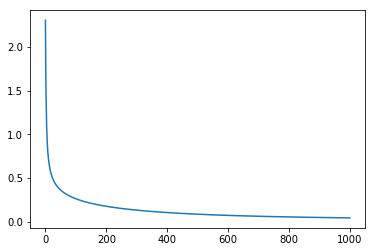

In [26]:
plt.plot(losses)

## Avaliando a acurácia tanto no conjunto de treinamento como no conjunto de testes

In [32]:
def getAccuracy(X,WT, Y):
    a,Y_hat = predict(X,WT)
    print(type(a))
    print(type(Y_hat))
    
    accuracy = sum(Y_hat == Y)/(float(len(Y)))
    return accuracy

In [33]:
print('Training Accuracy: ', getAccuracy(X_bias,WT,Y))

<class 'torch.FloatTensor'>
<class 'torch.LongTensor'>
Training Accuracy:  1.0


In [49]:
testY = torch.from_numpy(Y_test[:n_test]).type(torch.LongTensor)
testX = torch.from_numpy(X_test[:n_test].reshape((-1,28*28))/255.).type(torch.FloatTensor)
ones = torch.ones(n_test,1)
ones = ones.type(torch.FloatTensor)
testX_bias = torch.cat((ones, testX), 1)


In [50]:
print(type(testX_bias))

<class 'torch.FloatTensor'>


In [64]:
print('Test Accuracy: ', getAccuracy(testX_bias,WT,testY))

typo <class 'tuple'>
Test Accuracy:  0.905


## Matriz de confusão com dados de treinamento e teste

In [52]:
val, y_pred_max = predict(X_bias,WT)
y_pred_max = y_pred_max.numpy()
print(y_pred_max.shape)

(1000,)


In [54]:
val2, y_pred_max_test = predict(testX_bias,WT)
y_pred_max_test = y_pred_max_test.numpy()
print(y_pred_max_test.shape)

(200,)


In [56]:
print('Matriz de confusão (Treino):')
display(pd.crosstab(y_pred_max, Y.numpy()))

Matriz de confusão (Treino):


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,97,0,0,0,0,0,0,0,0,0
1,0,116,0,0,0,0,0,0,0,0
2,0,0,99,0,0,0,0,0,0,0
3,0,0,0,93,0,0,0,0,0,0
4,0,0,0,0,105,0,0,0,0,0
5,0,0,0,0,0,92,0,0,0,0
6,0,0,0,0,0,0,94,0,0,0
7,0,0,0,0,0,0,0,117,0,0
8,0,0,0,0,0,0,0,0,87,0


In [61]:

print('Matriz de confusão (Teste):')
display(pd.crosstab(y_pred_max_test, testY.numpy()))
#display(pd.crosstab(predict(testX_bias,WT), testY))

Matriz de confusão (Teste):


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,16,0,0,0,0,0,0,0,0,0
1,0,28,0,0,0,0,0,0,0,0
2,0,0,13,1,0,1,1,0,0,0
3,1,0,1,13,0,0,0,2,0,1
4,0,0,1,0,24,0,0,1,0,0
5,0,0,0,2,0,19,0,0,0,0
6,0,0,1,0,2,0,19,0,0,0
7,0,0,0,0,0,0,0,20,0,1
8,0,0,0,0,0,0,0,0,10,0
